In [1]:
# Manipulação de Dados
import pickle
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

# Otimização
from skopt import gp_minimize, BayesSearchCV
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

/home/bobcasta/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
# Carrega o dataset com preços de alugueis da cidade de São Paulo
df = pd.read_csv('sao-paulo-properties.csv')

In [3]:
# Substituindo " " por "_" nos nomes das variáveis
df.columns = df.columns.str.replace(' ', '_')

In [4]:
# Dataset com preços de alugéis de imóveis
rent = df[df['Negotiation_Type'] == 'rent']
rent.reset_index(drop=True, inplace=True)

In [5]:
# Criando a variável "Comercial"
rent['Comercial'] = (rent['Price'] >= 8000) | (rent['Size'] >= 200)
rent['Comercial'] = rent['Comercial'].map({True: 1, False: 0})
  
# Valor do metro quadrado por apartamento
rent['m2_Value'] = np.round((rent['Price'] + rent['Condo']) / rent['Size'], 2)

In [6]:
# Lista de variáveis para exclusão
to_drop = ['New', 'District', 'Negotiation_Type', 'Property_Type', 'Latitude', 'Longitude']

# Exclui a variável "Property_Type" de dados
rent.drop(to_drop, axis=1, inplace=True)

rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,Comercial,m2_Value
0,930,220,47,2,2,1,1,0,0,0,0,24.47
1,1000,148,45,2,2,1,1,0,0,0,0,25.51
2,1000,100,48,2,2,1,1,0,0,0,0,22.92
3,1000,200,48,2,2,1,1,0,0,0,0,25.00
4,1300,410,55,2,2,1,1,1,0,0,0,31.09


In [7]:
# Seleciona os atributos e a variável alvo para a divisão
X = rent.drop('Price', axis=1)
y = rent['Price']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Cria uma função com as métricas de avaliação
def performace(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return (print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAE das previsões é {}'.format(round(mae, 2))))

Random Forest Regressor: -353962.742039 (422887.533843)
Gradient Boosting Regressor: -365606.538752 (298342.479728)
XGBoost Regressor: -326840.760699 (358952.300867)
CatBoost Regressor: -247491.358461 (558505.519185)
Light Gradient Boosting Regressor: -381217.583263 (512298.108961)


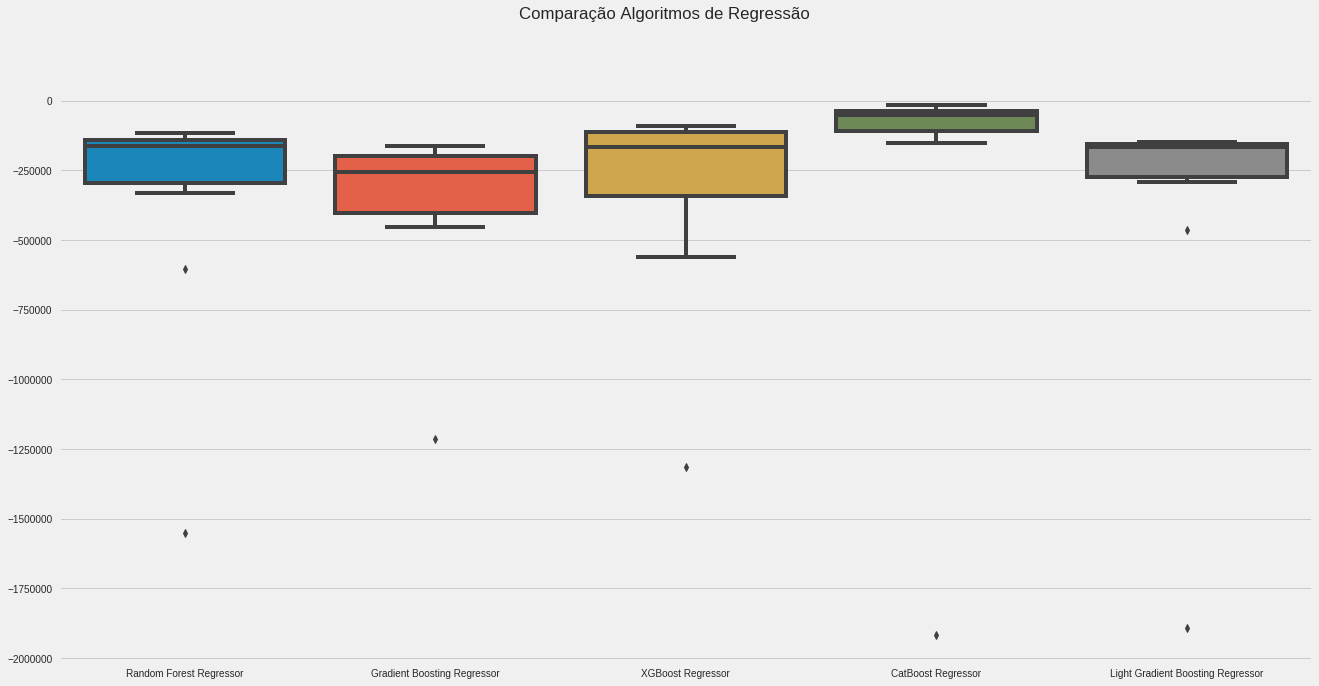

In [9]:
# Instanciando e criando uma lista com os modelos
modelos = []
modelos.append(('Random Forest Regressor', RandomForestRegressor(random_state=42)))
modelos.append(('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)))
modelos.append(('XGBoost Regressor', XGBRegressor(random_state=42)))
modelos.append(('CatBoost Regressor', CatBoostRegressor(random_state=42, verbose=False)))
modelos.append(('Light Gradient Boosting Regressor', LGBMRegressor(random_state=42)))

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor modelo por meio de uma validação cruzada
for nome, modelo in modelos:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot dos modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Regressão')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.show()

In [10]:
# Instancia do CatBoost Regressor
catboost = CatBoostRegressor(random_state=42, 
                             verbose=False)

# Treina o modelo
catboost.fit(X_train, y_train)

# Armazena as previsões em uma variável
pred = catboost.predict(X_test)

# Realiza a avalição por meio da função perfomace
performace(y_test, pred)

MSE das previsões é 88771.42
RMSE das previsões é 297.95
MAE das previsões é 72.67


In [11]:
# Instanciando o modelo
catboost_reg = CatBoostRegressor(eval_metric='RMSE', 
                                 random_state=42,
                                 verbose=False)

# A lista de hiperparâmetros que queremos otimizar. 
space  = [Integer(10, 1000, name='iterations'),
          Real(1e-5, 1e-1, 'log-uniform', name='learning_rate'),
          Real(1e-5, 10, 'log-uniform', name='random_strength'),
          Integer(1, 10, name= 'depth'),
          Real(0.05, 1.0, name='subsample'),
          Real(0.0, 1.0, name='bagging_temperature'),
          Integer(1, 250, name='border_count'),
          Integer(2, 10, name='l2_leaf_reg')]

# permite que sua função objetivo receba os parâmetros como argumentos de palavras-chave.
@use_named_args(space)
def objective(**params):
    catboost_reg.set_params(**params)

    return -np.mean(cross_val_score(catboost_reg, 
                                    X_train, 
                                    y_train, 
                                    cv=10, 
                                    n_jobs=-1, 
                                    scoring="neg_mean_squared_error"))

In [12]:
# Buscando os melhores hiperparâmetros
cat_gp = gp_minimize(objective,          # Função a ser minimizada
                     space,              # Espaços dos hiperparâmetros a ser otimizado
                     n_calls=50,         # Número de rodadas para otimização
                     n_random_starts=10, # Número de avaliações de pontos aleatórios antes de aproximar a função.
                     random_state=42, 
                     verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.3232
Function value obtained: 11354044.3758
Current minimum: 11354044.3758
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.8964
Function value obtained: 5279626.7653
Current minimum: 5279626.7653
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.4030
Function value obtained: 11979481.0798
Current minimum: 5279626.7653
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.2529
Function value obtained: 7892234.4345
Current minimum: 5279626.7653
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.8809
Function value obtained: 2619437.6062

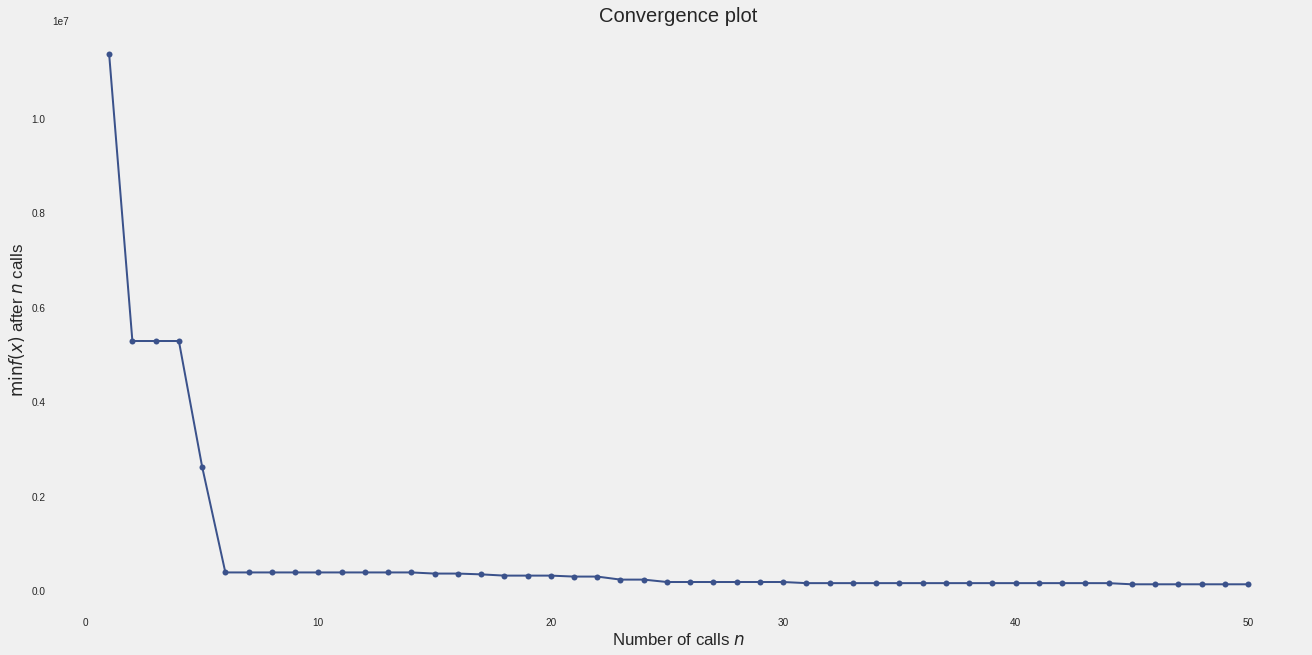

In [13]:
# Plot da convergência do Processo Gaussiano.
plot_convergence(cat_gp)
plt.show()

In [14]:
# Hiperparâmetros escolhidos durante a otimização
print('Melhores parâmetros para maximização do MSE score: ', cat_gp.x)

Melhores parâmetros para maximização do MSE score:  [657, 0.1, 0.0004965828069895046, 4, 0.8275472462941521, 0.9146569730898453, 233, 2]


In [15]:
# Instanciando o modelo com os melhores parâmetros
cat_opt = CatBoostRegressor(iterations=657,
                            learning_rate=0.1, 
                            random_strength=0.0004965828069895046, 
                            depth=4,
                            subsample=0.8275472462941521,
                            bagging_temperature=0.9146569730898453,
                            border_count=233,
                            l2_leaf_reg=2,
                            eval_metric='RMSE',
                            random_state=42,
                            verbose=False)
    
# Treinando o modelo com as variáveis selecionadas
cat_opt.fit(X_train, y_train)

# Realizando as previsões
pred = cat_opt.predict(X_test)

In [16]:
performace(y_test, pred)

MSE das previsões é 69559.06
RMSE das previsões é 263.74
MAE das previsões é 89.67


In [17]:
# Dump do Modelo
pickle.dump(cat_opt, open('Model/Rental_CatBoost.pkl', 'wb'))